# Analysis Of News Source Exposure On Google News

Here, we analyse the prominence of various news sources appearing within the search results of the Google News search engine, through data obtained as part of the Australian Search Experience research project.


In [1]:
from analysis_publishers import *

### [1] Retrieving Results From ASE Dataset

The ASE dataset resides on a Google Cloud Console Bigquery SQL dataset. Of interest within the dataset is records relating to the __Google News__ search platform.

The data takes the form of 'search results' (i.e., results as they are presented on a page returned for a given search query).

#### Preliminaries:

##### Keywords

Search queries have been collected for a set of predefined keywords relating to two categories ('Australian Politics' and 'Global Issues'). The keywords pertaining to each of these categories are given as follows:

1. __Australian Politics:__ <span style="color:blue">
    * Adam Bandt
    * Anthony Albanese
    * Barnaby Joyce
    * Greens
    * Labor Party
    * Liberal Party
    * National Party
    * One Nation
    * Pauline Hanson
    * Scott Morrison
    </span>
2. __Global Issues:__ <span style="color:blue">
    * Afghanistan
    * COP26
    * COVID
    * Feminism
    * Lockdown
    * Quarantine
    * Renewable energy
    * Tokyo 2021
    * Tokyo Olympics
    * Travel rules
    * Vaccine
    </span>

##### Data Donations

The collected search results comprise the 'data donations' of participants (citizen scientists) of the ASE research project. A data donation is a collection of search results returned for a search query of a given keyword.

We retrieve the following attributes of each given search result:

| Attribute         | Description                                                  |
| ----------------- | ------------------------------------------------------------ |
| Keyword           | The search topic that is queried within the Google News search platform that yields the given search result. |
| List Index        | The numerical ranking of the search result within the page of search results for the given data donation. |
| Source URL        | The URL of the website from which the search result is being returned. |
| Publisher         | The name of the publisher associated with the search result. |
| Activation Code   | The unique identifier associated with the individual who donated the search result. |
| Time Of Retrieval | The time at which the search result was retrieved.           |

<span style="color:red">__Note:__ _While the ASE dataset also provides an ID that can be used to group search results by their respective data donations, no aspect of the analysis that follows requires the said attribute and so it is excluded._</span>

These attributes are visualised as follows:

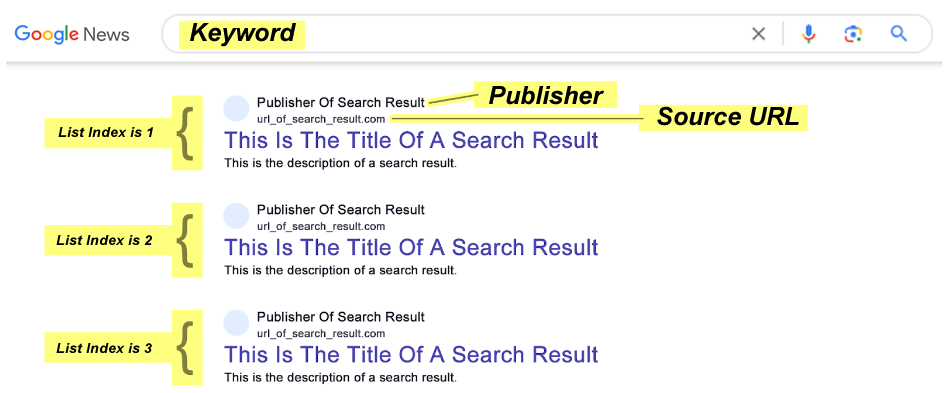

The search results obtained from the ASE dataset have been filtered to include only those which satisfy the following conditions:

1. Having been derived from both 'desktop' and 'mobile' device configurations. The ASE dataset provides search results for both desktop browsers __and__ mobile devices [1]. We have included both configurations within the search results obtained for the analysis.
2. Having a search ranking within the top 10 results shown for the given query of the search page. This means having a list index that is at minimum 1, and at maximum 10.
3. Having been retrieved after the time of 12:00AM 1st of September, 2021, and before the time of 12:00AM 1st of January, 2022 (according to Brisbane Eastern Standard Time (EST)).

[1] - Bruns, A. (2022). Australian search experience project: background paper.

This step produces two files, corresponding to the two keyword categories 'Australian Politics' (k1) and 'Global Issues' (k2):

* `output.jsond.temporal.k1`
* `output.jsond.temporal.k2`

<span style="color:green">___The contents of this step can be found within the function `process_1` of the `analysis_publishers.py` Python implementation.___</span>

### [2] Retaining First Level Domains

In the previous step, it was indicated that certain search results pertained to web sessions based on mobile devices. In such cases, said search results may link to 'mobile' versions of the relevant publishers' websites (provided they accomodate mobile viewing experiences).

This is reflected in the source URL of publisher - for instance, consider 'The Sydney Morning Herald' news outlet. Their standard Australian website URL is:

https://www.smh.com.au

Whereas, the website URL returned to individuals of their mobile device search experiences is as follows:

https://amp.smh.com.au

There is no single convention of URL subdomains for mobile device search experiences. From curation of the results in the ASE dataset, we identify a few subdomains that consistently route to mobile device websites:

1. <span style="color:blue">"AMP"</span> which abbreviates <span style="color:blue">"Accelerated Mobile Pages"</span> (e.g. amp.smh.com.au) [1]
2. <span style="color:blue">"M"</span> which abbreviates <span style="color:blue">"Mobile"</span> (e.g. m.epochtimes.com) [2]
2. <span style="color:blue">"MOBILE"</span> (e.g. mobile.abc.net.au) [2]

[1] _AMP as your web framework_. AMP. Archived from the original on April 23, 2021. Retrieved Aug 08, 2023.
https://web.archive.org/web/20210423154051/https://blog.amp.dev/2019/05/01/amp-as-your-web-framework/

[2] _Mobilize_. Stacks4Stacks. Retrieved Aug 08, 2023.
https://stacks4stacks.com/mobilize/#:~:text=You'll%20notice%20the%20letter,mobile%20version%20of%20the%20website.

For further steps of the analysis, we intend to use the source URL of any publisher as its unique identifier, and so it is important to merge both desktop and mobile source URLs. Beyond dealing with mobile device pages, removing all sub-level domains (SLDs) is necessary to achieve this objective.

We achieve this objective through use of the Python `tld` module [3].

[3] _tld 0.13_. PyPI. Retrieved Aug 08, 2023.
https://pypi.org/project/tld/

This step produces two files that implement the adjustments, again corresponding to the two keyword categories 'Australian Politics' (k1) and 'Global Issues' (k2):

* `output.jsond.temporal.k1.p2`
* `output.jsond.temporal.k2.p2`

<span style="color:green">___The contents of this step can be found within the function `process_2` of the `analysis_publishers.py` Python implementation.___</span>

### [3] Cleaning First Level Domains

To further mitigate malformed FLDs (beyond removing SLDs), a further two steps are executed on the `output.jsond.temporal.k1.p2` and `output.jsond.temporal.k2.p2` files as follows:

1. All entries that do not resolve to FLDs are excluded.
2. All entries that begin with the <span style="color:blue">"./articles"</span> suffix are removed.

<span style="color:red">__Note:__ _It is a feature of Google search platforms that certain source URLs are transformed to local URLs of the form "./articles/...". As these transformations make the URL undiscernable, we have to remove them._</span>

A portion of entries have been disincluded - these are visualised as follows:


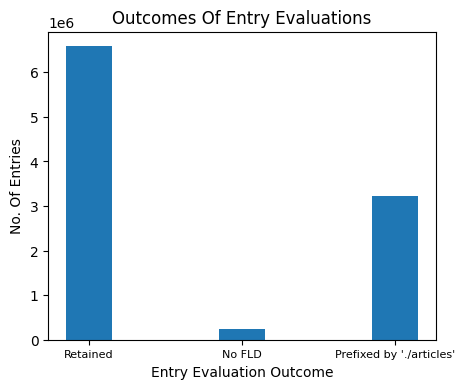

In [2]:
graph_malformed_fld_stats()

As a result of this step, a total of 4,799 distinct FLDs are retained at the file:

* `all_flds.json`

Furthermore, this step also produces two files that implement the adjustments, as given below:

* `output.jsond.temporal.k1.p3`
* `output.jsond.temporal.k2.p3`

<span style="color:green">___The contents of this step can be found within the function `process_3` of the `analysis_publishers.py` Python implementation.___</span>



### [4] Determining Country Of Operation

The next step requires that we determine the countries of operation for all publishers, as indicated by their FLDs.

Firstly, we load in the contents of the FLDs retrieved from the `all_flds.json` file of the previous step.

#### GeoLite Domain Lookup

...

#### WHOIS Domain Lookup

Then we apply the `whois` Python module to retrieve domain registration information from the WHOIS domain lookup register for each of the FLDs. An example of the information returned for the FLD <span style="color:blue">_myeasternshoremd.com_</span> is given below (although we are only really interested in the `country` attribute):

```
{
  "name": "APG Media of Chesapeake",
  "org": "APG Media of Chesapeake",
  "address": "29088 Airpark Dr",
  "city": "Easton",
  "country": "US"
}
```

The contents of this step is contained in the file `whois_fld_data.json`. While domain lookup data exists for some FLDs, others may return that the owners of the FLDs request that the domain data stay hidden (indicated by a returned `DATA REDACTED`, `REDACTED FOR PRIVACY`, or `null` response).

#### Country Code TLDs

As an alternative method, certain FLDs contain TLDs that indicate the country of operation (e.g. the '.us' TLD indicates the United States Of America). A full list of country codes used as suffixes are available at [1] and [2]. We apply a snippet of JavaScript indicated in `country_codes.js` on the webpage of [2], yielding the `country_codes` dictionary object, which is then dumped into the file `wiki_country_suffixes.json`.

Additionally, we recognise that some country codes are ambiguous, and have as such been excluded; we note them below:
* "md" : Can mean either "Moldova" or "Medical Doctor"
* "tm" : Can mean either "Turkmenistan" or "Trademark"
* "tv" : Can mean either "Tuvalu" or "Television"
* "yt" : Can mean either "Mayotte" or "Youtube"

The adjusted country code TLDs are dumped in the file `wiki_country_suffixes_unambiguous.json`.

Thereafter, we check the country codes contained in said file against all FLDs - where applicable, country codes are identified and the resulting data is dumped into the file `country_suffix_data.json`.

#### Chosen Methods

Finally, we load in the entries from the `output.jsond.temporal.k1.p3` and `output.jsond.temporal.k2.p3` files generated in the previous step. For each entry, the country of operation is determined by a choice of the aforementioned methods described below:

<span style="color:blue">1. __Country-Code TLD:__ We assess whether the FLD has a country code TLD.</span>

<span style="color:red">_In some cases, the Country-Code TLD is not accurate (e.g. 'pedestrian.tv' resolves to Tuvaltu, however their country of operation is the United States Of America). For this, the method below is applied:_</span>

<span style="color:blue">2. __WHOIS:__ We assess whether the FLD has WHOIS lookup data.</span>

<span style="color:red">_In some cases, the WHOIS lookup data is not accurate (e.g. 'theguardian.com' does not resolve within the WHOIS domain lookup). For this, the method below is applied:_</span>

<span style="color:blue">3. __GeoLite2:__ We assess whether the FLD has GeoLite2 data.</span>

<span style="color:red">_In some cases, the GeoLite2 data is not accurate (e.g. the 'Daily Mail' operates in both the UK and Australia - their Australian operation is indicated by the appendage of the '/au/' subpage, however their domain resolves to the UK). For this, the method below is applied:_</span>

<span style="color:blue">4. __Australian subpage or Country Code TLD:__ We assess whether the FLD has an 'Australia' subpage (indicated as either "/au/" or "/australia-news/").</span>

<span style="color:red">__Note:__ _We can only determine Australian subpages for source URLs that we have manually identified - as such, not all possible Australian subpages are accounted as thy may be arbitrarily conceived by the relative publishers._</span>

The hierarchy of chosen methods is given below:

```
[Australian subpage] -> [Country-Code TLD] -> [GeoLite2] -> [WHOIS] -> [NULL]
```

Where a country of operation cannot be determined for any of the above methods, a `null` response is instead given.

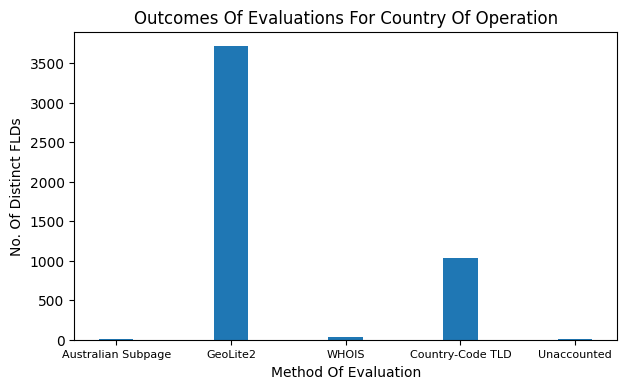

In [3]:
graph_country_of_operation_n_accounted_by()

<span style="color:red">__Note:__ _In some cases, an FLD may be accounted by more than two methods, as FLDs are assessed on an 'entry by entry' basis (to accomodate nuances where the country of operation might be derived from the source URL as opposed to the FLD itself), and not by each distinct FLD._</span>

This step produces two files that implement the adjustments, as given below:

* `output.jsond.temporal.k1.p4`
* `output.jsond.temporal.k2.p4`

<span style="color:green">___The contents of this step can be found within the function `process_4` of the `analysis_publishers.py` Python implementation.___</span>

### [5] Grouping Entries By Domains

In this step, the entries produced within the `output.jsond.temporal.k1.p4` and `output.jsond.temporal.k2.p4` files are grouped together by keyword categories (`k1` or `k2`), keywords, and FLDs. The entries are also grouped by whether or not the data donations have been averaged to remove duplicate data donations submitted by the same individuals. The contents is dumped into the file `entries_by_domain.json`. An excerpt below conveys the structure of said file:

```
{
   "distinct": {
      "k1": {
         "Greens": {
            "theguardian.com (AU)": [
               {
                  "activation_code": "g39wox0kmdb9q7zypfnifk8oogeh8iq7",
                  "list_index": 4.48,
                  "time_of_retrieval": [
                     1639969947,
                     1631868184,
                     1631621657,
                     1631507517,
                     1633996342,
                     1631701711,
                     1632838466,
                     1631592603,
                     1633038601,
                     1632386788,
                     1633940613,
                     1634082635,
                     1634015261,
                     1633372019,
                     1631270537,
                     1633357860,
                     1633852915,
                     1631660570,
                     1631439395,
                     1633782475,
                     1633304908,
                     1633927209,
                     1639369785,
                     1633319520,
                     1640477361
                  ]
               },
               ...
```

The excerpt above conveys that for the `distinct` case (i.e., relating to the case where data donations of distinct individuals are aggregated and averaged), for the keyword category `k1` (relating to Australian politics), for the query of the keyword `Greens`, the individual uniquely identified by the activation code `g39wox0kmdb9q7zypfnifk8oogeh8iq7` observed the FLD `theguardian.com (AU)` at the list index of `4.48`, averaged over 25 observations.

<span style="color:red">__Note:__ _In the `distinct` case, the number of observations observed by each individual are irrelevant (hence why they are not given by an attribute). This differs from the `nondistinct` case (i.e., relating to the case where data donations of distinct individuals are not aggregated)._</span>

For contrast, the same file also conveys the `nondistinct` case, given by the second excerpt below:

```
...
"nondistinct": {
      "k1": {
         "Greens": {
            "theguardian.com (AU)": [
               {
                  "activation_code": "g39wox0kmdb9q7zypfnifk8oogeh8iq7",
                  "list_index": 8,
                  "time_of_retrieval": 1639969947
               },
               {
                  "activation_code": "g39wox0kmdb9q7zypfnifk8oogeh8iq7",
                  "list_index": 4,
                  "time_of_retrieval": 1632640535
               },
               {
                  "activation_code": "7k1s1gc72yghiwm8abh8cbmc2j56u4o4",
                  "list_index": 6,
                  "time_of_retrieval": 1632649552
               },
                ...
```

As can be seen above (and different to the first excerpt), the entries are not aggregated by the individuals who contributed them.

<span style="color:green">___The contents of this step can be found within the function `process_5` of the `analysis_publishers.py` Python implementation.___</span>

### [6] Bucketing Results Longitudinally

In this step, we create intervals that longitudinally group the data contained in the `entries_by_domain.json` (from the previous step) by the 'Time Of Retrieval' attribute. As UNIX timestamps, the bounds of the period of data collection are given as follows:

* __Start of Time Window__: <span style="color:blue">1630418400</span> converts to <span style="color:blue">"Wednesday, September 1, 2021 12:00:00 AM GMT+10:00"</span>
* __End of Time Window__: <span style="color:blue">1630418400</span> converts to <span style="color:blue">"Saturday, January 1, 2022 12:00:00 AM GMT+10:00"</span>

For our analysis, we have chosen three-day intervals - as UNIX timestamps are notated in seconds, the interval size is calculated as <span style="color:blue">259200</span> seconds <span style="color:blue">(3 days * 24 hours * 60 minutes * 60 seconds)</span>.

The datastructure generated by this step is virtually identical to that of the previous step, with the exception that the data is now also contextualised by UNIX timestamps representing the time window starting at and including the UNIX timestamp, up until but not including 259,200 seconds after said time interval.

For example, the UNIX timestamp __1630677600__ would indicate any time greater than or equal to __1630677600__, but less than __1630936800__.

An excerpt of the contents, dumped into the file `entries_by_domain_temporal.json`, is given as follows:

```
{
   "distinct": {
      "k1": {
         "Greens": {
            "theguardian.com (AU)": {
               "1630677600": [
                  {
                     "list_index": 5.055555555555555,
                     "activation_code": "f8ozkuxuvqhwd1bdir8vsfn3laxrt2bs",
                     "time_of_retrieval": [
                        1630900830
                     ]
                     ...
```

<span style="color:green">___The contents of this step can be found within the function `process_6` of the `analysis_publishers.py` Python implementation.___</span>

### [7] Determining Confidence Of Results

In this step, the `entries_by_domain.json` and `entries_by_domain_temporal.json` files are evaluated to determine the confidence of the results.

For both files, for both distinct and non-distinct data donations, both keyword categories, each keyword, and each FLD (and furthermore the interval for the temporal case), the following statistics are calculated for the list indexes that comprise the contextualisation:

* Average List Index:
* Frequency Of Observations:
* Normality Test [1]:
    * Normality Test Outcome: Success or failure, depending on whether the p-value is smaller than the alpha value of 0.05 (allowing 5% error)
    * P-Value
    * Statistic: Summation of the squares of both the Skew Test and Excess Kurtosis Test.

The results are dumped to the files `entries_by_domain_summarised.json` and `entries_by_domain_temporal_summarised` respectively.

[1] _scipy.stats.normaltest_. SciPy v1.11.4 Manual. Retrieved 11 Aug 2023.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

<span style="color:green">___The contents of this step can be found within the function `process_7` of the `analysis_publishers.py` Python implementation.___</span>

### [8] Assembling Graphable Results

In this step, the `entries_by_domain_summarised.json` and `entries_by_domain_temporal_summarised.json` files are evaluated to compile graphable datasets.

These are contextualised by the following parametrics:

1. Whether or not the outcomes of normality tests are regarded.
2. Whether or not we are grouping distinct individuals who submitted data donations.

Furthermore, the graphable datasets are grouped by the following attributes:

* The keyword categories (`k1` and `k2`)
* Longitudinality of results
* The keyword queried (where applicable)
* The 'Frequency Of Observation' and 'Average List Index' statistics
* The FLD (i.e., domain)

<span style="color:red">__Note:__ _For both recorded statistics, FLDs that were not observed are disincluded. _</span>

This step produces the following files:

* `master_graphable_dataset.k1.distinct.json`
* `master_graphable_dataset.k1.distinct.normality.json`
* `master_graphable_dataset.k1.nondistinct.json`
* `master_graphable_dataset.k1.nondistinct.normality.json`
* `master_graphable_dataset.k2.distinct.json`
* `master_graphable_dataset.k2.distinct.normality.json`
* `master_graphable_dataset.k2.nondistinct.json`
* `master_graphable_dataset.k2.nondistinct.normality.json`

<span style="color:green">___The contents of this step can be found within the function `process_7` of the `analysis_publishers.py` Python implementation.___</span>